# Lab 10: Unsupervised Learning
COSC 410: Applied Machine Learning\
Colgate University\
*Prof. Apthorpe*

This lab is due to Gradescope by the beginning of lab next week (2:45p on 4/14). You may work with a partner on this lab – if you do, submit only one solution as a “group” on Gradescope.


## Introduction

Cancer is the second leading cause of death in the United States (after heart disease), and the development of general therapeutics still poses a significant challenge for medical researchers. It has been said that cancer is a "disease of multicellularity," involving a human's own cells "going rogue" by expressing genes they shouldn't and replicating out of control. The advent of fast inexpensive DNA and RNA sequencing techniques now makes it possible for scientists to collect large-scale data about the underlying genetic causes of cancer in an effort to find effective treatments. In this lab, you will experiment with unsupervised dimensionality reduction and clustering algorithms to try to answer the following cancer research questions:

**1. Are different cancer types (e.g. lung vs. kidney) the result of the same changes in gene expression occurring in different parts of the body, or do they represent "different diseases" with mostly unique changes in gene expression?**

**2. Might it be possible to make high-confidence diagnoses of patients' cancer types from gene expression data alone?**

You will work with a RNA-Sequencing dataset from "The Cancer Genome Atlas Pan-Cancer Analysis Project" (Nature Genetics, 2013) to answer these questions. In human cells, genes encoded in DNA are translated into messenger RNA that is then transcribed into proteins. RNA-sequencing is a method for measuring which genes are currently being expressed (and to what extent). The process involves extracting messenger RNA from cell samples, sequencing the RNA, and mapping the sequences of A, U, C, and G nucleotides back to the known DNA genome. Comparing gene expression between samples from individuals with different cancer types allows researchers to test whether over- or under-expression of particular genes may be correlated with the disease. The dataset we are working with contains a random sample of gene expressions from five different types of tumor: BRCA (breast invasive carcinoma), KIRC (kidney renal clear cell carcinoma), COAD (colon adenocarcinoma), LUAD (lung adenocarcinoma), and PRAD (prostate adenocarcinoma).

You will note that the gene expression dataset *does* have ground-truth labels, even though unsupervised learning is primarily intended for data without existing labels.  However, it is common practice to use unsupervised ML with labeled data, because 1) good 2D visualizations are useful for interpreting data even if it has already been labeled, and 2) we can test whether identified clusters align with existing labels to know whether clustering future unlabeled data is likely to be effective.

## Provided Files
 * `Lab10.ipynb`: This file
 * `TCGA-PANCAN-HiSeq-801x20531.csv`: CSV file with gene expression levels of patients with one of five different cancer types
 * `TCGA-PANCAN-HiSeq-801x20531_labels.csv`: CSV file with the each patient's cancer type
 
## Part 1: Data Import and Preprocessing

The following cells import libraries and implement functions to load the dataset and create scatterplots. You do not need to modify these cells. Look up the [Matplotlib scatter() documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html) to understand the `plot_scatter` function

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras as ks
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import completeness_score

In [2]:
def load_cancer_gene_expression():
    X = pd.read_csv("TCGA-PANCAN-HiSeq-801x20531.csv")
    y = pd.read_csv("TCGA-PANCAN-HiSeq-801x20531_labels.csv")["Class"]
    X = X.drop("Unnamed: 0", axis=1)
    y = LabelEncoder().fit_transform(y)
    return X, y


def plot_scatter(X, labels_for_coloring, cmap="tab10"):
    plt.scatter(x=X[:,0], y=X[:,1], c=labels_for_coloring, cmap=cmap)

## Part 2. Data Exploration

In the following cells, familiarize yourself with the cancer dataset as we have done with other datasets throughout the semester. Check the size of the examples and labels, the counts of examples from different cancer types, etc. 

In [3]:
X_cancer, y_cancer = load_cancer_gene_expression()

In [4]:
print(X_cancer.shape)
print(y_cancer.shape)

uniqLabels = np.unique(y_cancer, return_counts=True)[1]

print(uniqLabels)


(801, 20531)
(801,)
[300  78 146 141 136]


**Question 1:** Describe the facets of the cancer dataset you think are most important to know before beginning a ML pipeline

- The dataset's distribution of different patients' cancer types is uneven
- There is no 'non-cancer' label in the dataset
- The dataset has a large number of feature/columns/dimensions

## Part 2. Dimensionality Reduction

Complete the `pca()`, `tsne()`, and `autoencode()` functions in the following cells.

  * `pca(X, n_components)`: Performs PCA on example matrix `X`, producing a new matrix with the same number of examples (rows) and `n_components` features (columns). Returns the new matrix. [Scikit-Learn PCA Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA)
  
  * `tsne(X, n_components)`: Performs t-SNE on example matrix `X`, producing a new matrix with the same number of examples (rows) and `n_components` features (columns). Returns the new matrix. [Scikit-Learn t-SNE Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)
 
  * `autoencode(X, n_components, hidden_layer_nodes, epochs=25)`: Creates and trains a stacked autoencoder to reduce matrix `X` to `n_components` dimensions. Returns the new matrix. `hidden_layer_nodes` should be a list with the numbers of nodes in each layer **between** the input layer and the middle encoding layer. Refer to the course textbook and/or the Keras documentation for examples. Note that you will want to be careful about your choice of activation and loss functions. 

In [10]:
def pca(X, n_components):
    model = PCA(n_components=n_components)
    print(model.fit_transform(X))
    return model.fit_transform(X)

In [6]:
def tsne(X, n_components):
    model = TSNE(n_components=n_components)
    print(model.fit_transform(X))
    return model.fit_transform(X)

In [12]:
def autoencode(X, n_components, hidden_layer_nodes, epochs=50):
    encoder = ks.models.Sequential()
    for i in range(len(hidden_layer_nodes)):
        encoder.add(ks.layers.Dense(hidden_layer_nodes[i], activation="relu"))
    encoder.add(ks.layers.Dense(n_components, activation='linear'))

    decoder = ks.models.Sequential()
    for j in range(len(hidden_layer_nodes)):
        decoder.add(ks.layers.Dense(hidden_layer_nodes[len(hidden_layer_nodes) - j - 1], activation="relu"))
    decoder.add(ks.layers.Dense(X.shape[1], activation='linear'))

    model = ks.models.Sequential([encoder, decoder])
    
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])
    early_stopping_callback = ks.callbacks.EarlyStopping(monitor="mean_squared_error", min_delta=0, patience=epochs, restore_best_weights=True)
    model.fit(X, X, epochs=epochs, batch_size=32, callbacks=[early_stopping_callback])
    return encoder.predict(X)

Use your dimensionality reduction functions to produce 2D visualizations of the cancer dataset. Create 3 plots, one each using PCA, t-SNE, and an autoencoder. Color the points in the plot according to their ground-truth label (use the `plot_scatter` function from Part 1).  Experiment with different autoencoder architectures find a network that results in a good 2D embedding.

[[-62.75541522 -94.07197347]
 [ -2.43289636  90.58584189]
 [-71.26685284  -8.06460783]
 ...
 [ 10.48626145  21.57059462]
 [-55.06360486 -92.39477806]
 [-49.10303378 -50.99763916]]


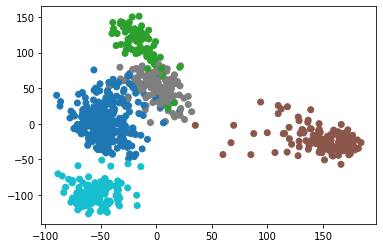

In [8]:
# Cancer Dataset: PCA
X_reduct = pca(X_cancer, 2)
plot_scatter(X_reduct, y_cancer)

C:\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[[-41.889595    4.484376 ]
 [  9.903641   28.116922 ]
 [-40.88931    -2.9740431]
 ...
 [-13.344922   23.71489  ]
 [-39.07039     2.1761835]
 [-33.31756     2.9403536]]


C:\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


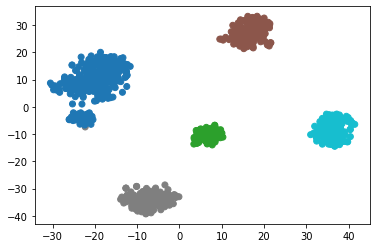

In [9]:
# Cancer dataset: t-SNE
X_reduct = tsne(X_cancer, 2)
plot_scatter(X_reduct, y_cancer)

Epoch 1/50
26/26 [==============================] - 1s 10ms/step - loss: 22.5427 - mean_squared_error: 22.5427
Epoch 2/50
26/26 [==============================] - 0s 11ms/step - loss: 2.2802 - mean_squared_error: 2.2802
Epoch 3/50
26/26 [==============================] - 0s 12ms/step - loss: 1.7949 - mean_squared_error: 1.7949
Epoch 4/50
26/26 [==============================] - 0s 12ms/step - loss: 1.7780 - mean_squared_error: 1.7780
Epoch 5/50
26/26 [==============================] - 0s 11ms/step - loss: 1.7751 - mean_squared_error: 1.7751
Epoch 6/50
26/26 [==============================] - 0s 11ms/step - loss: 1.7730 - mean_squared_error: 1.7730
Epoch 7/50
26/26 [==============================] - 0s 11ms/step - loss: 1.7758 - mean_squared_error: 1.7758
Epoch 8/50
26/26 [==============================] - 0s 11ms/step - loss: 1.7846 - mean_squared_error: 1.7846
Epoch 9/50
26/26 [==============================] - 0s 11ms/step - loss: 1.7795 - mean_squared_error: 1.7795
Epoch 10/50
26/26

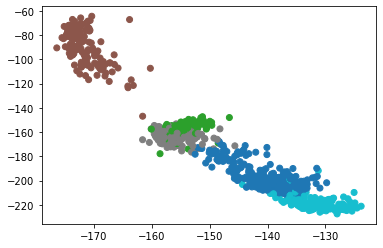

In [13]:
# Cancer dataset: Autoencoder

plot_scatter(autoencode(X_cancer, 2, [16]), y_cancer)

**Question 2**: Which dimensionality reduction technique produced the best 2D visualization of the dataset? What criteria did you use to define "best"?

tSNE produced the best 2D visualization of the dataset; "best" in this case means clearest separation between each category in the dataset.

**Question 3:** What variations to the autoencoder did you try to improve the 2D representation? Which made a noticeable difference? Why might this be the case? 

Variations attempted to improve 2D representation: Changing the number of hidden layers and number of nodes in those layers, raising the epoch count and implementing early stopping. All variations except changing the number of layers/nodes made a noticeable difference; likely because more epochs allow the training loss to go down further, and early stopping retrieves the best performing model that has the best dimensionality reduction performance.

## Part 3. Clustering

Complete the following function to perform clustering on an unlabeled dataset:

* `kmeans(X, n_clusters)`: Clusters `X` into `n_clusters` clusters using the k-means algorithm. Returns an integer array with the cluster indices assigned to each example in `X`. For example, if index 1 of the return value is 7, this means that example 1 (i.e. `X[1,:]`) has been assigned to cluster 7. Scikit-Learn [k-means documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#). 

In [11]:
def kmeans(X, n_clusters):
    model = KMeans(n_clusters=n_clusters)
    return model.fit_predict(X)

In the following cell

1. Cluster the full cancer dataset (original dimensionality) into 5 clusters using `kmeans()`
2. Reduce the dataset to 2D using `tsne()`
3. Plot the 2D dataset **colored by cluster labels**

C:\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


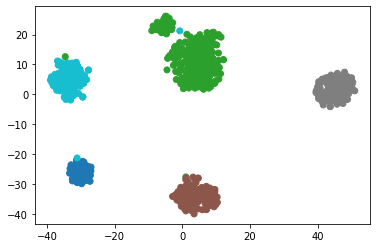

In [48]:
X_km = kmeans(X_cancer, 5)
X_tsne = tsne(X_cancer, 2)

plot_scatter(X_tsne, X_km)

**Question 4:** Why did we choose to find 5 clusters? 

Because the original dataset had 5 unique classes to which examples were assigned

**Question 5:** How do the unsupervised k-means clusters compare to the ground truth labels? *(Visually compare against your plot from Part 2)*

K-means clustering mostly correctly clusters the dataset and the graph is very similar to the ground truth tSNE plot, but there are some outliers which are clustered with an unrelated group (visible on the scatterplot with some datapoints being in groups they don't belong)

**Question 6:** What are some **pros** and **cons** of clustering a dataset in its original high dimensionality versus clustering after dimensionality reduction?

Clustering after dimensionality reduction reduces/eliminates the case of outliers being clustered into unrelated groups, but dimensionality reductions may omit and alter the original high-dimensional data in ways that might affect the accuracy of the clustering

In the following cell, compute and print the [completeness score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.completeness_score.html#sklearn.metrics.completeness_score) to quantitatively evaluate the effectiveness of k-means clustering on the cancer dataset given the known ground-truth labels

In [49]:
# Todo
print(completeness_score(y_cancer, X_km))

0.9763990539625916


**Question 7:** Explain this completeness score and what it means for the cancer dataset as you would to a **layperson** with no specific ML or CS knowledge.  

The completescore score denotes how much of the ML model's cancer type predictions line up with the cancer type labels in the dataset

## Part 4. Final Questions

**Question 8:** What does the data analysis in Part 2 suggest about **Research Question 1**? Support your argument by referring to your plots. What does this imply about why "curing cancer" is such a difficult medical problem?

**1. Are different cancer types (e.g. lung vs. kidney) the result of the same changes in gene expression occurring in different parts of the body, or do they represent "different diseases" with mostly unique changes in gene expression?**

The data analysis, especially the plots produced by tSNE, indicate that there is little overlap between the features exhibited by different cancer types, because the different clusters on the plot have no overlap. Thus, the data analysis indicates that different cancer types represent "different diseases" with mostly unique changes in gene expression. This helps explain why "curing cancer" is a difficult problem; because each cancer type is a different "disease" with different changes in gene expression, a genetic cure for one type of cancer may not necessarily be applicable to another.

**Question 9:** What does the data analysis in Part 3 suggest about **Research Question 2**? Support your argument by referring to your plots. 

**2. Might it be possible to make high-confidence diagnoses of patients' cancer types from gene expression data alone?**

The data analysis indicates that there is little overlap between the features exhibited by different cancer types, because the different clusters on the plot have no overlap. Thus, this indicates that different cancer types likely exhibit unique gene expressions that are unlikely to be mistaken for one another. Thus, it may be possible to make high-confidence diagnoses of patients' cancer types from gene expression data alone.

**Question 10:** We could have used a supervised ML approach to address **Research Question 2** given that we have ground truth labels for the cancer dataset. However, in what other real-world situations would effective clustering of unlabeled medical diagnostic results be useful for doctors?

Clustering of unlabeled medical diagnostic results would be useful for doctors to produce preliminary findings for diagnosis of novel diseases based on gathered medical data, before in-depth research can be done on the symptoms and features of those novel diseases to distinguish them.